# Computational materials science

## Introduction
In this tutorial, you will use `AiiDA-WorkTree` to carry out a DFT calculation using Quantum ESPRESSO.

## Requirements
To run this tutorial, you need to install `aiida-worktree`, `aiida-quantumespresso` and `aiida-pseudo`. Open a terminal and run:

```console
pip install aiida-worktree aiida-quantumespresso aiida-pseudo
aiida-pseudo install sssp -x PBEsol
```

Start the AiiDA daemon if needed:
```console
verdi daemon start
```

Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='4a9501fb20364cecb99920cadf27b238' name='xing'>

## First workflow: calculate the energy of N2 molecule

### Create a PW node
aiida-quantumespresso provides a CalcJob: `PwCalculation` to run a PW calculation. Let's register it as a node:

In [3]:
from aiida_worktree import build_node, node

# register node
ndata = {"path": "aiida_quantumespresso.calculations.pw.PwCalculation"}
pw_node = build_node(ndata)

The inputs and outputs of the `PwCalculation` is automatically generated for the new node. One can create a node instance and inpsect its inputs and outputs:

In [3]:
node = pw_node()
# only show first level inputs and outputs
print("Inputs:")
for input in node.inputs:
    if "." not in input.name:
        print(f"  - {input.name}")
print("Outputs:")
for output in node.outputs:
    if "." not in output.name:
        print(f"  - {output.name}")

Inputs:
  - metadata
  - code
  - monitors
  - remote_folder
  - structure
  - parameters
  - settings
  - parent_folder
  - vdw_table
  - pseudos
  - parallelization
  - kpoints
  - hubbard_file
Outputs:
  - remote_folder
  - remote_stash
  - retrieved
  - output_parameters
  - output_structure
  - output_trajectory
  - output_band
  - output_kpoints
  - output_atomic_occupations


### Prepare the input datas

In [8]:
from aiida_worktree import WorkTree
from aiida import load_profile
from aiida.orm import Dict, KpointsData, StructureData, load_code, load_group
from ase.build import molecule

load_profile()
# create input structure node
mol = molecule("N2")
mol.center(vacuum=1.5)
mol.pbc = True
structure_n2 = StructureData(ase=mol)
# create the PW node
code = load_code("pw-7.2@localhost")
paras = Dict({
        "CONTROL": {
            "calculation": "scf",
        },
        "SYSTEM": {
            "ecutwfc": 30,
            "ecutrho": 240,
            "occupations": "smearing",
            "smearing": "gaussian",
            "degauss": 0.1,
        },
    })
kpoints = KpointsData()
kpoints.set_kpoints_mesh([1, 1, 1])
# Load the pseudopotential family.
pseudo_family = load_group('SSSP/1.2/PBEsol/efficiency')
pseudos = pseudo_family.get_pseudos(structure=structure_n2)
#
metadata = {
    'options': {'resources': {
                'num_machines': 1,
                'num_mpiprocs_per_machine': 1,
            },
        }
    }


### Define a worktree

In [5]:
wt = WorkTree("energy_n2")
# structure node
structure1 = wt.nodes.new("AiiDANode", "n2", value=structure_n2)
# pw node
pw1 = wt.nodes.new(pw_node, name="pw1")
pw1.set({"code": code,
        "parameters": paras,
        "kpoints": kpoints,
        "pseudos": pseudos,
        "metadata": metadata
        })
wt.links.new(structure1.outputs[0], pw1.inputs["structure"])
wt.submit(wait=True, timeout=200)

[INFO] 2023-07-29 14:28:44 nodetree: Create NodeTree: energy_n2


### Check status and results
Get the result of the nodes:

In [6]:
print('Energy of an un-relaxed N2 molecule: {:0.3f}'.format(pw1.node.outputs.output_parameters.get_dict()["energy"]))

Energy of an un-relaxed N2 molecule: -547.169


Generate node graph from the AiiDA process:

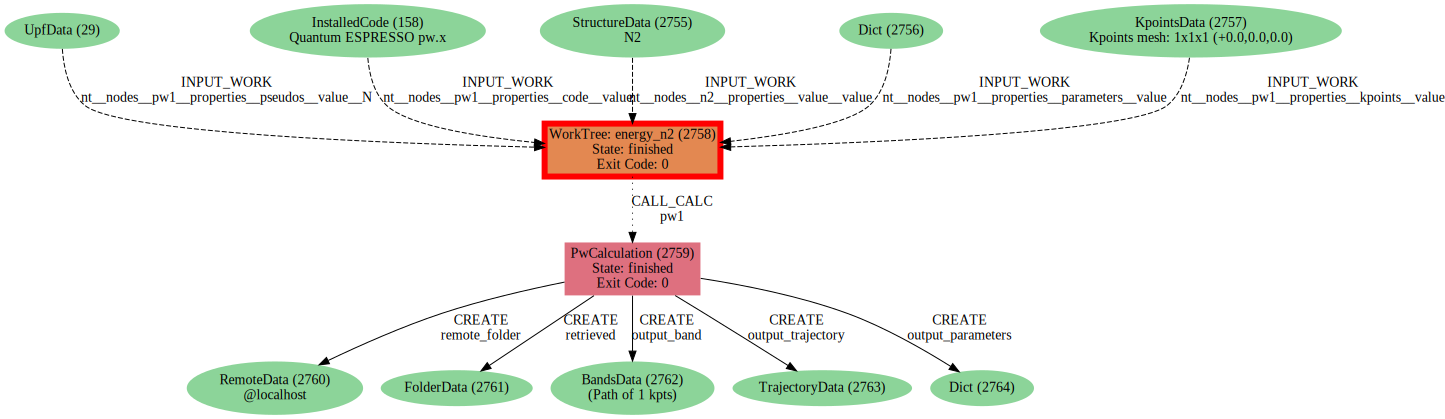

In [7]:
from aiida_worktree.utils import generate_node_graph
generate_node_graph(wt.pk)

## Second workflow: atomization energy of N2 molecule

The atomization energy of $N_2$ is defined as the energy difference between the $N_2$ molecule and two isolated N atoms.
```python
e_atomization = 2 * e_atom - e_molecule
````

### Define a calcfunction to calculate the atomization energy

In [8]:
from aiida_worktree import node
from aiida.engine import calcfunction


@node(outputs = [["General", "energy"]])
@calcfunction
def atomization_energy(output_atom, output_mol):
    from aiida.orm import Float
    e = output_atom["energy"]*output_mol["number_of_atoms"] - output_mol["energy"]
    return Float(e)

Create the structure of nitrogen Atom.

In [9]:
from ase import Atoms
from aiida.orm import StructureData

atoms = Atoms("N")
atoms.center(vacuum=1.5)
atoms.pbc = True
structure_n = StructureData(ase=atoms)

### Create a worktree

In [10]:
from aiida_worktree import WorkTree
from aiida.orm import Dict, KpointsData, StructureData, load_code, load_group

wt = WorkTree("atomization_energy")

wt.nodes.new("AiiDANode", "n2", value=structure_n2)
wt.nodes.new("AiiDANode", "n", value=structure_n)
# create the PW node
pw_n = wt.nodes.new(pw_node, name="pw_n")
pw_n.set({"code": code, "parameters": paras, "kpoints": kpoints,
          "pseudos": pseudos, "metadata": metadata
        })
pw_n2 = wt.nodes.new(pw_node, name="pw_n2")
pw_n2.set({"code": code, "parameters": paras, "kpoints": kpoints,
          "pseudos": pseudos, "metadata": metadata
        })
# create the node to calculate the atomization energy
atomization = wt.nodes.new(atomization_energy, name="atomization_energy")
wt.links.new(wt.nodes["n"].outputs[0], pw_n.inputs["structure"])
wt.links.new(wt.nodes["n2"].outputs[0], pw_n2.inputs["structure"])
wt.links.new(pw_n.outputs["output_parameters"], atomization.inputs["output_atom"])
wt.links.new(pw_n2.outputs["output_parameters"], atomization.inputs["output_mol"])
wt.submit(wait=True, timeout=300)


[INFO] 2023-07-29 14:29:20 nodetree: Create NodeTree: atomization_energy


In [11]:
wt.update()
print('Atomization energy: {:0.3f} eV'.format(atomization.node.outputs.result.value))


Atomization energy: 14.451 eV


Generate node graph from the AiiDA process:

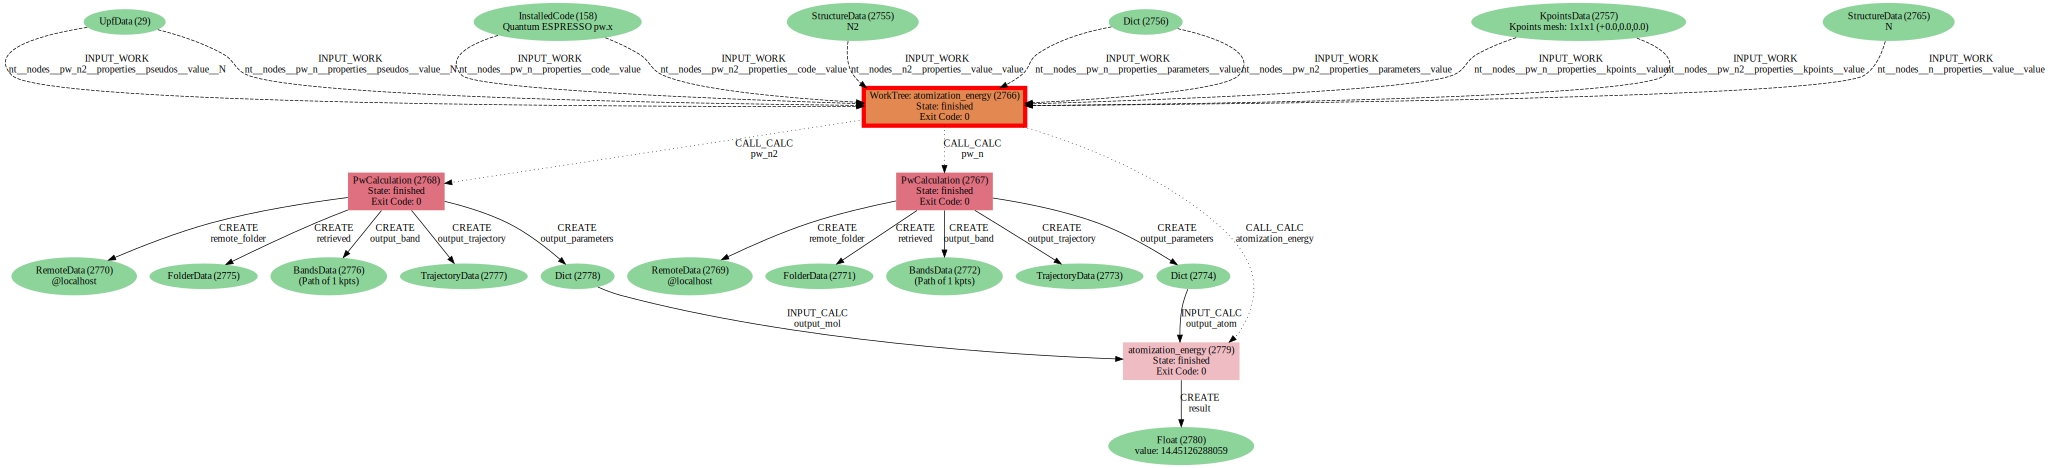

In [12]:
from aiida_worktree.utils import generate_node_graph
generate_node_graph(wt.pk)

## Third workflow: equation of state of Si crystal

Create node to scale the structure.

In [5]:
from aiida import orm
from aiida.engine import calcfunction

@node(outputs=[["General", "structures"]])
@calcfunction
def scale_structure(structure, scales):
    atoms = structure.get_ase()
    structures = {}
    for i in range(len(scales)):
        atoms1 = atoms.copy()
        atoms1.set_cell(atoms.cell * scales[i], scale_atoms=True)
        structure = orm.StructureData(ase=atoms1)
        structures[f"s_{i}"] = structure
    return {"structures": structures}


Create node to use `PwCalculation` to calculate the energy of the scaled structure. We use a node group to launch the calculations in parallel.

In [17]:

# Output result from context
@node.group(outputs=[["ctx.result", "result"]])
def all_scf(structures, code, parameters, kpoints, pseudos, metadata):
    from aiida_worktree import WorkTree
    # register node
    ndata = {"path": "aiida_quantumespresso.calculations.pw.PwCalculation"}
    pw_node = build_node(ndata)
    wt = WorkTree("all_scf")
    # pw node
    for key, structure in structures.items():
        pw1 = wt.nodes.new(pw_node, name=f"pw1_{key}")
        pw1.set(
            {
                "code": code,
                "parameters": parameters,
                "kpoints": kpoints,
                "pseudos": pseudos,
                "metadata": metadata,
                "structure": structure,
            }
        )
        pw1.to_ctx = [["output_parameters", f"result.{key}"]]
    return wt

Create a node to fit the equation of state.

In [18]:

@node()
@calcfunction
# because this is a calcfunction, and the input datas are dynamic, we need use **datas.
def eos(**datas):
    from ase.eos import EquationOfState

    volumes = []
    energies = []
    for _key, data in datas.items():
        volumes.append(data.dict.volume)
        energies.append(data.dict.energy)
        unit = data.dict.energy_units
    #
    eos = EquationOfState(volumes, energies)
    v0, e0, B = eos.fit()
    eos = orm.Dict(
        {
            "unit": unit,
            "v0": v0,
            "e0": e0,
            "B": B,
        }
    )
    return eos

Build the worktree and submit the calculations.

In [19]:
from ase.build import bulk
from aiida_worktree import WorkTree
#-----------------------------------
# create input structure node
si = orm.StructureData(ase=bulk("Si"))
kpoints = orm.KpointsData()
kpoints.set_kpoints_mesh([2, 2, 2])
# Load the pseudopotential family.
pseudos = pseudo_family.get_pseudos(structure=si)
#-----------------------------------
wt = WorkTree("eos")
scale_structure1 = wt.nodes.new(
    scale_structure, name="scale_structure1", structure=si, scales=[0.95, 1.0, 1.05]
)
all_scf1 = wt.nodes.new(all_scf, name="all_scf1")
all_scf1.set(
    {
        "code": code,
        "parameters": paras,
        "kpoints": kpoints,
        "pseudos": pseudos,
        "metadata": metadata,
    }
)
eos1 = wt.nodes.new(eos, name="eos1")
wt.links.new(scale_structure1.outputs["structures"], all_scf1.inputs["structures"])
wt.links.new(all_scf1.outputs["result"], eos1.inputs["datas"])
wt.submit(wait=True, timeout=300)


[INFO] 2023-08-04 11:03:21 nodetree: Create NodeTree: eos


Check the status and result of the calculations.

In [29]:
wt.update()
print('B: {B}\nv0: {v0}\ne0: {e0}\nv0: {v0}'.format(**eos1.node.outputs.result.get_dict()))

B: 0.45468565129136
v0: 43.304370225826
e0: -306.67269385923
v0: 43.304370225826


Generate node graph from the AiiDA process:

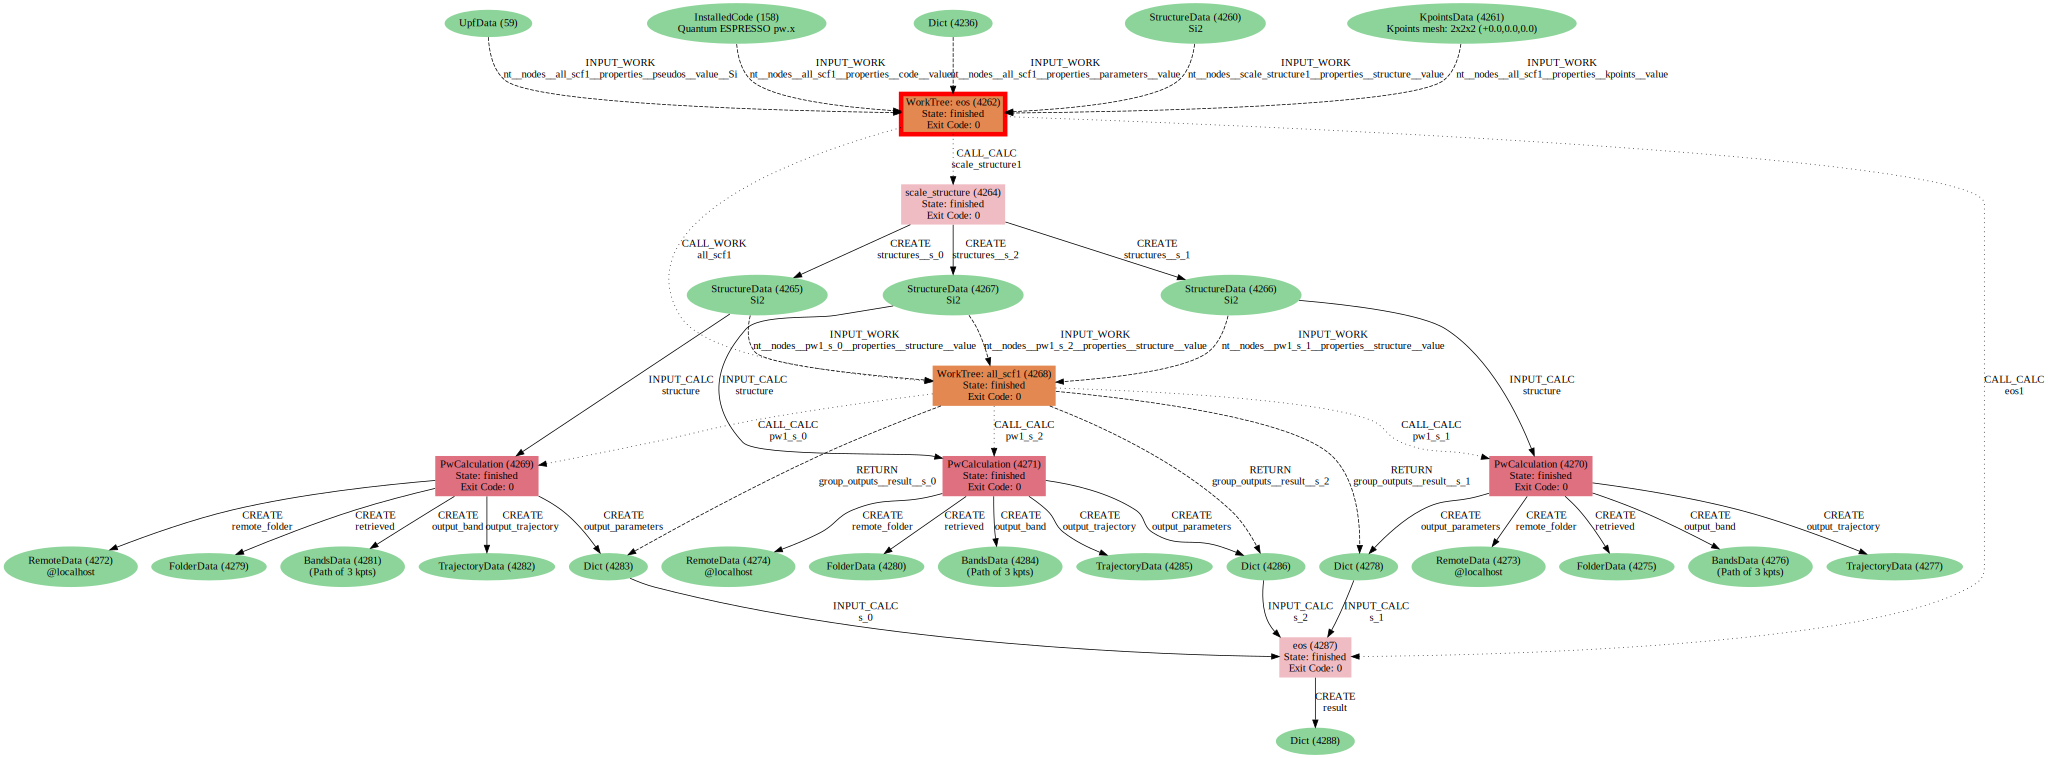

In [16]:
from aiida_worktree.utils import generate_node_graph
generate_node_graph(wt.pk)

## Use already existing workchain
Can we register a node from a workchain? Can we set the a input item of a namespace? Yes, we can!

Here we build a node from the `PwRelaxWorkChain`.

In [13]:
from aiida_worktree.decorator import build_node

# register node
ndata = {"path": "aiida_quantumespresso.workflows.pw.relax.PwRelaxWorkChain"}
pw_relax_node = build_node(ndata)

In the `PwRelaxWorkChain`, one can set the relax type (`calculation` key) in the input namespace `base.pw.parameters`. Now we create a new node to update the pw parameters.

In [14]:
from aiida_worktree.decorator import node
from aiida.engine import calcfunction


@node()
@calcfunction
def pw_parameters(paras, relax_type):
    paras1 = paras.clone()
    paras1["CONTROL"]["calculation"] = relax_type
    return paras1

Now, we create the worktree to relax the structure of N2 molecule.

In [15]:
wt = WorkTree("test_pw_relax")
# structure node
wt.nodes.new("AiiDANode", "n2", value=structure_n2)
# pw node
pw_relax1 = wt.nodes.new(pw_relax_node, name="pw_relax1")
pw_relax1.set({
        "base": {
                "pw": {
                        "code": code,
                        "pseudos": pseudos,
                        "metadata": metadata
                },
                "kpoints": kpoints,
                },
        
        })
paras_node = wt.nodes.new(pw_parameters, "parameters",
                          paras = paras,
                          relax_type = "relax")
wt.links.new(wt.nodes["n2"].outputs[0], pw_relax1.inputs["structure"])
wt.links.new(paras_node.outputs[0], pw_relax1.inputs["base.pw.parameters"])
wt.submit(wait=True, timeout=200)

[INFO] 2023-07-29 14:30:03 nodetree: Create NodeTree: test_pw_relax


In [16]:
wt.update()
print('Energy of a relaxed N2 molecule: {:0.3f}'.format(pw_relax1.node.outputs.output_parameters.get_dict()["energy"]))

Energy of a relaxed N2 molecule: -547.232


Generate node graph from the AiiDA process:

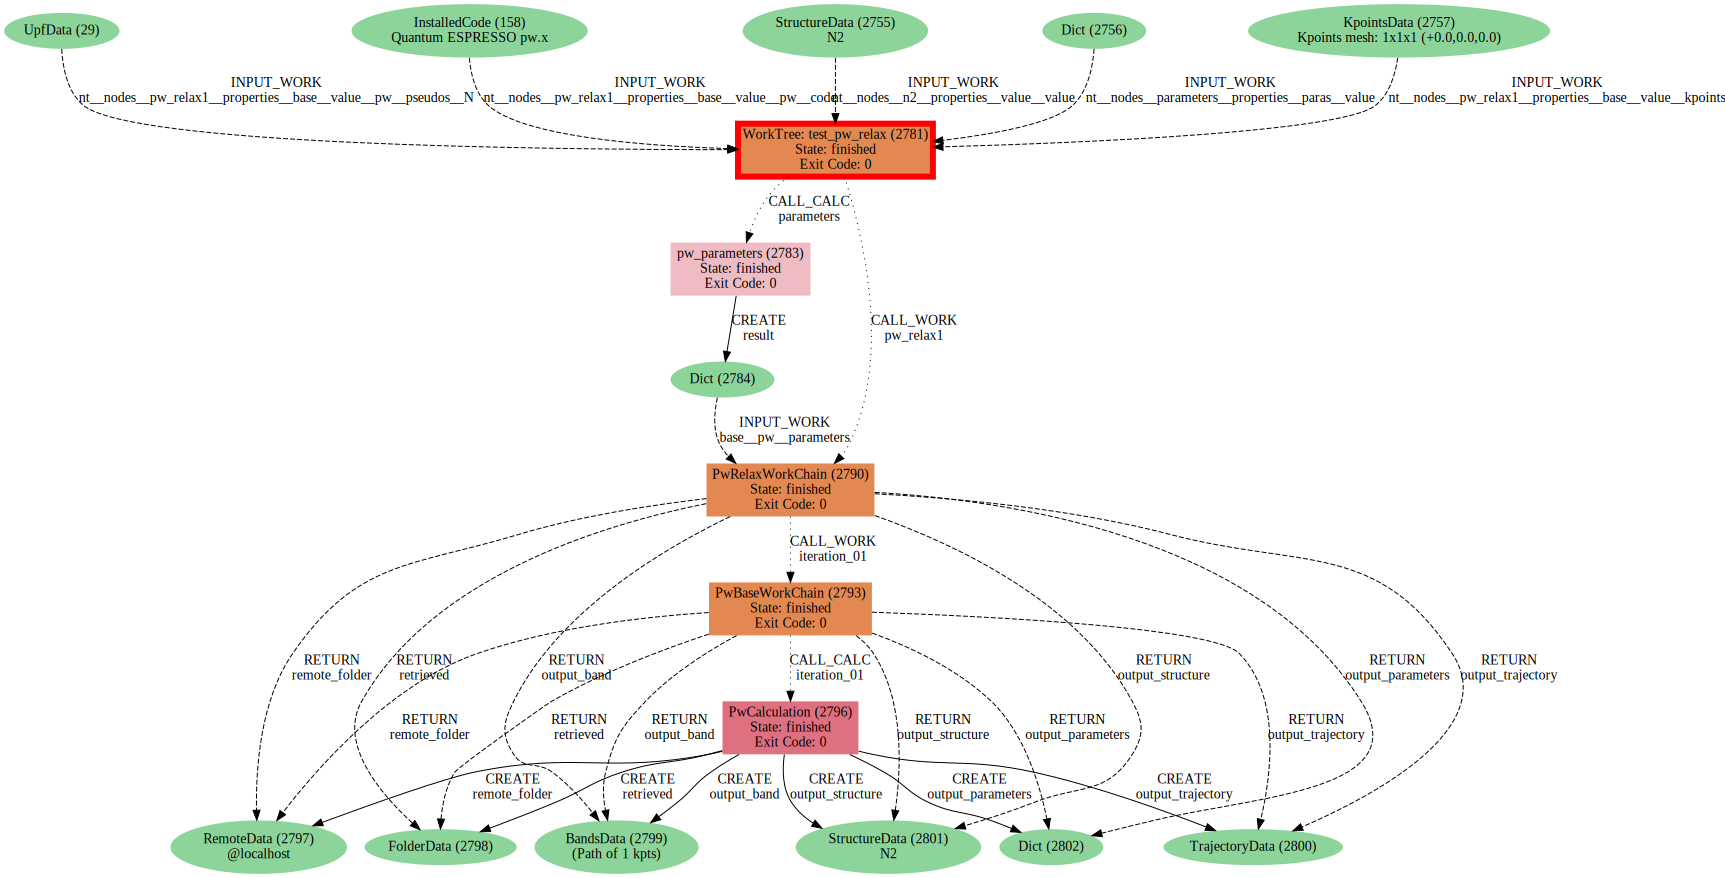

In [17]:
from aiida_worktree.utils import generate_node_graph
generate_node_graph(wt.pk)

## Use `protocol` to set input parameters
The aiida-quantumespresso package supports setting input parameters from protocol. For example, the PwRelaxWorkChain has a `get_builder_from_protocol` method. In this tutorial, we will show how to use the `protocol` to set the input parameters inside the WorkTree.

In [3]:
from aiida_worktree import build_node, WorkTree
from ase.build import bulk
from aiida import orm
from pprint import pprint

# register node
pw_relax_node = build_node(
    {"path": "aiida_quantumespresso.workflows.pw.relax.PwRelaxWorkChain"}
)
code = orm.load_code("pw-7.2@localhost")
wt = WorkTree("test_pw_relax")
structure_si = orm.StructureData(ase=bulk("Si"))
pw_relax1 = wt.nodes.new(pw_relax_node, name="pw_relax1")
# set the inputs from the protocol
# this will call the `PwRelaxWorkChain.get_builder_from_protocol` method
# to set the inputs of the workchain
pw_relax1.set_from_protocol(
    code,
    structure_si,
    protocol="fast",
    pseudo_family="SSSP/1.2/PBEsol/efficiency"
)
# we can now inspect the inputs of the workchain
print("The inputs for the PwBaseWorkchain are:")
print("-"*80)
pprint(pw_relax1.inputs["base"].value)
print("\nThe input parameters for pw are:")
print("-"*80)
pprint(pw_relax1.inputs["base"].value['pw']['parameters'].get_dict())

The inputs for the PwBaseWorkchain are:
--------------------------------------------------------------------------------
{'kpoints_distance': <Float: uuid: f38f586e-9e72-4fbd-985b-39a8682322c0 (unstored) value: 0.5>,
 'kpoints_force_parity': <Bool: uuid: 3be45a23-8510-490b-8f20-f63689da7b1b (unstored) value: False>,
 'metadata': {},
 'pw': {'code': <InstalledCode: Remote code 'pw-7.2' on localhost pk: 158, uuid: cd7f5a2a-3d4e-4335-b6a4-d114dba06ab9>,
        'metadata': {'options': {'max_wallclock_seconds': 43200,
                                 'resources': {'num_machines': 1},
                                 'stash': {},
                                 'withmpi': True}},
        'monitors': {},
        'parameters': <Dict: uuid: 42462743-3995-4721-a188-8fbefb37eb69 (unstored)>,
        'pseudos': {'Si': <UpfData: uuid: 86dda7cc-d764-4291-a827-5cd9d2b7a07d (pk: 59)>}}}

The input parameters for pw are:
--------------------------------------------------------------------------------

One can also adjust the parameters of the `PwRelaxWorkChain` to from protocol.

In [ ]:
# For example, we want to remove the `base_final_scf` from the inputs, so that the `PwRelaxWorkChain` will not run the `base_final_scf` step.
pw_relax1.inputs["base_final_scf"] = None
# submit the worktree
wt.submit(wait=True, timeout=200)
